# Exploratory Data Analysis of HAR70+ Dataset
The Human Activity Recognition 70+ (HAR70+) dataset can be found [here](https://archive.ics.uci.edu/dataset/780/har70) (corresponding [paper](https://www.mdpi.com/1424-8220/23/5/2368)). The HAR70+ dataset contains sensor data from 18 fit-to-frail older adult subjects (70-95 years old) wearing two 3-axial accelerometers (attached to the right thigh and lower back) for around 40 minutes during a semi-structured free-living protocol.

**Table of Contents**

0. [Dataset Information](#0-dataset-information)
1. [Setup](#1-setup)
2. [Examine Dataset](#2-examine-dataset)
    1. [Examine Timestamps](#21-examine-timestamps)
    2. [Examine Labels](#22-examine-labels)
    3. [Descriptive Statistics](#23-descriptive-statistics)
    4. [Missing Values](#24-missing-values)

## 0. Dataset Information 
*The following information is taken verbatim from the dataset webpage.*

**For what purpose was the dataset created?**

The purpose was to train machine learning models for human activity recognition on professionally-annotated accelerometer data of fit-to-frail older adults.

**Additional Information**

The HAR70+ dataset contains recordings of 18 older adult participants wearing two 3-axial Axivity AX3 accelerometers for around 40 minutes in a semi-structured free-living setting. The participants' age was between 70 and 95 years. Five of the 18 subjects used walking aids during data recording. One sensor was attached to the right front thigh and the other to the lower back. The provided sampling rate is 50Hz. Video recordings of a chest-mounted camera were used to annotate the performed activities frame-by-frame.

Each subject's recordings are provided in a separate .csv file. One such .csv file contains the following columns:
1. `timestamp`: date and time of recorded sample
2. `back_x`: acceleration of back sensor in $x$-direction (down) in the unit $g$
3. `back_y`: acceleration of back sensor in $y$-direction (left) in the unit $g$
4. `back_z`: acceleration of back sensor in $z$-direction (forward) in the unit $g$
5. `thigh_x`: acceleration of thigh sensor in $x$-direction (down) in the unit $g$
6. `thigh_y`: acceleration of thigh sensor in $y$-direction (right) in the unit $g$
7. `thigh_z`: acceleration of thigh sensor in $z$-direction (backward) in the unit $g$
8. `label`: annotated activity code

The dataset contains the following **annotated activities** with the corresponding coding scheme:
1. Walking	
3. Shuffling
4. Stairs (ascending)	
5. Stairs (descending)	
6. Standing	
7. Sitting	
8. Lying

## 1. Setup

In [1]:
# Automatic reloading
%load_ext autoreload
%autoreload 2

In [ ]:
####################
# Required Modules #
####################

# Libs
import pandas as pd
import matplotlib.pyplot as plt

# Custom
from src.data_preparation import *

In [5]:
# Download HAR70+ dataset and save to 'data' directory
download_har70plus_dataset()

⬇️ Downloading HAR70+ dataset to data\har70.zip...
✅ Download complete: data\har70.zip
📦 Extracting dataset to data\har70plus...
✅ Files extracted to: data\har70plus


## 2. Examine Dataset
The dataset consists of 18 separate `csv` files (`501.csv` to `518.csv`), one for each subject. Let us examine just one of these files (the data from one subject).

In [6]:
# Load 501.csv
df = pd.read_csv("data/har70plus/501.csv")
df.head()

,timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
0,2021-03-24 14:42:03.839,-0.999023,-0.063477,0.140625,-0.980469,-0.112061,-0.048096,6
1,2021-03-24 14:42:03.859,-0.980225,-0.079346,0.140625,-0.961182,-0.121582,-0.051758,6
2,2021-03-24 14:42:03.880,-0.950195,-0.076416,0.140625,-0.949463,-0.080566,-0.067139,6
3,2021-03-24 14:42:03.900,-0.954834,-0.059082,0.140381,-0.957520,-0.046143,-0.050781,6
4,2021-03-24 14:42:03.920,-0.972412,-0.042969,0.142822,-0.977051,-0.023682,-0.026611,6


### 2.1. Examine Timestamps

Each sample (row) contains the sensor data for one time step.

In [7]:
# Check timestamp format
df['timestamp'].head()

0    2021-03-24 14:42:03.839
1    2021-03-24 14:42:03.859
2    2021-03-24 14:42:03.880
3    2021-03-24 14:42:03.900
4    2021-03-24 14:42:03.920
Name: timestamp, dtype: object

In [9]:
# Convert timestamp to datetime and calculate time differences (between consecutive time steps)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['timestamp_diff'] = df['timestamp'].diff().dt.total_seconds()

# Summary statistics of timestamp gaps
df['timestamp_diff'].describe()

count    103859.000000
mean          0.020241
std           0.027083
min           0.019000
25%           0.020000
50%           0.020000
75%           0.020000
max           4.861000
Name: timestamp_diff, dtype: float64

As we can see, the average time interval between consecutive time steps is 0.02 seconds (20 milliseconds), which aligns with the reported 50Hz sampling rate (1/50 = 0.02 seconds). However, there are occasional larger time gaps (up to 4.86 seconds for this subject), likely due to pauses in recording or missing data.

When constructing sequences of time steps for our time series dataset using a sliding window approach (slide window across time steps), we must account for discontinuities in the time series. Specifically, the sliding window cannot move across 'breakpoints' - points where the time gap between consecutive steps significantly exceeds the expected 0.02 seconds. These gaps indicate interruptions in data collection, and allowing the window to extend past them would create sequences that falsely assume temporal continuity.

We can identify these breakpoints like so:

In [10]:
# Identify breakpoints (where gaps are larger than expected 0.02s)
gap_threshold = 0.05  # Slightly higher than 0.02 to account for minor variations
breakpoints = df[df['timestamp_diff'] > gap_threshold].index

# Print breakpoints
print(f"Identified {len(breakpoints)} breakpoints at indices:", breakpoints.tolist())

Identified 10 breakpoints at indices: [4776, 11606, 16496, 23448, 23580, 26206, 26866, 29194, 97844, 103248]


Let's examine the breakpoint at index 4776:

In [12]:
df["timestamp"].iloc[4774: 4780]

4774   2021-03-24 14:43:39.319
4775   2021-03-24 14:43:39.340
4776   2021-03-24 14:43:40.520
4777   2021-03-24 14:43:40.540
4778   2021-03-24 14:43:40.560
4779   2021-03-24 14:43:40.580
Name: timestamp, dtype: datetime64[ns]

As we can see, there is a 1.18 second gap between time step 4776 and 4777.

### 2.2. Examine Labels

In [13]:
# See sample labels
df["label"].value_counts().sort_index()

label
1    62872
3     1876
4       92
5      504
6    14376
7    14562
8     9578
Name: count, dtype: int64

Two observations:
- The value `2` is unused for the class label, which matches the reported class mapping.
- There is a significant class imbalance.

The function below compiles the data across the 18 subjects into a single dataframe and remaps the class labels to be more appropriate for use with PyTorch.

In [17]:
df = load_har70_csv_files()

✅ Successfully loaded HAR70+ dataset (2259597 timestep samples).


The function above remaps the labels using the following mapping: `{1: 0, 3: 1, 4: 2, 5: 3, 6: 4, 7: 5, 8: 6}`.
The dataset now contains the following annotated activities with the new corresponding coding scheme:

0. Walking	
1. Shuffling
2. Stairs (ascending)	
3. Stairs (descending)	
4. Standing	
5. Sitting	
6. Lying

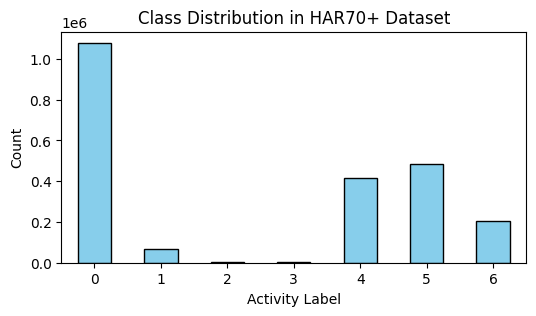

label
0    1079312
1      66058
2       4560
3       4978
4     418055
5     483452
6     203182
Name: count, dtype: int64

In [18]:
label_counts = df["label"].value_counts().sort_index()

plt.figure(figsize=(6, 3))
label_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel("Activity Label")
plt.ylabel("Count")
plt.title("Class Distribution in HAR70+ Dataset")
plt.xticks(rotation=0)
plt.show()
label_counts

Across all the data, we can see there is a major class imbalance across all time steps. The action of walking is overrepresented and the two actions of ascending/descending the stairs are underrepresented.

### 2.3. Descriptive Statistics

In [20]:
df.describe()

,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
count,2.259597e+06,2.259597e+06,2.259597e+06,2.259597e+06,2.259597e+06,2.259597e+06,2.259597e+06
mean,-8.699344e-01,-3.316850e-02,2.342491e-02,-6.796213e-01,2.774742e-03,-3.841220e-01,2.389224e+00
std,2.689122e-01,1.513270e-01,4.327357e-01,5.517539e-01,2.736956e-01,5.127760e-01,2.427948e+00
min,-4.333252e+00,-2.031006e+00,-2.204834e+00,-7.942139e+00,-5.142578e+00,-7.593750e+00,0.000000e+00
25%,-9.929200e-01,-1.096190e-01,-2.751460e-01,-9.873050e-01,-1.166990e-01,-9.860840e-01,0.000000e+00
50%,-9.392090e-01,-2.172900e-02,-1.125490e-01,-9.357910e-01,-1.562500e-02,-1.877440e-01,1.000000e+00
75%,-8.281250e-01,5.078100e-02,3.125000e-01,-7.055700e-02,1.123050e-01,-4.150000e-03,5.000000e+00
max,3.630370e-01,1.576660e+00,1.179199e+00,3.395264e+00,5.725098e+00,3.953369e+00,6.000000e+00


### 2.4. Missing Values

In [19]:
# Check for missing values
df.isnull().sum()

timestamp    0
back_x       0
back_y       0
back_z       0
thigh_x      0
thigh_y      0
thigh_z      0
label        0
dtype: int64

There are no missing values in the dataset.